In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

In [240]:
kernel = RBF()
# kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5)

In [241]:
def expected_improvement(grid, sample_values, gpr, exploration_param=0.01):
    means,stds = gpr.predict(grid, return_std=True)

    stds.reshape(-1,1)

    curr_max = np.max(sample_values)

    with np.errstate(divide="warn"):
        temp = means - curr_max - exploration_param
        ei = temp * norm.cdf(temp / stds) + stds * norm.pdf(temp / stds)
        ei[stds==0] = 0

    return ei

In [242]:
def get_next_location(acquisition_func,sample_values,gpr,bounds,n_restarts=25):
    min_val = 1
    min_x = None

    def min_obj(grid):
        # Minimization objective is the negative acquisition function
        return -acquisition_func(grid.reshape(-1, 1), sample_values, gpr)
    
    for x0 in np.random.uniform(bounds[:,0], bounds[:,1], size=n_restarts):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_x = res.x
            min_val = res.fun    
            
    return min_x.reshape(-1, 1)

In [243]:
def func(x):
    return -np.sin(3*x) - x**2 + 0.7*x

In [244]:
interval = np.array([[-1.0, 2.0]])
grid_size = 101

kernel_param = 2
explore_param = 0.1

max_error = 1e-5

# starting values
points_vector_init = np.array([[-0.7], [2.0]])
func_vector_init = func(points_vector_init)

grid = np.linspace(interval[:,0],interval[:,1],grid_size).reshape(1,-1)

d:\anaconda3\envs\bayesopt\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\anaconda3\envs\bayesopt\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


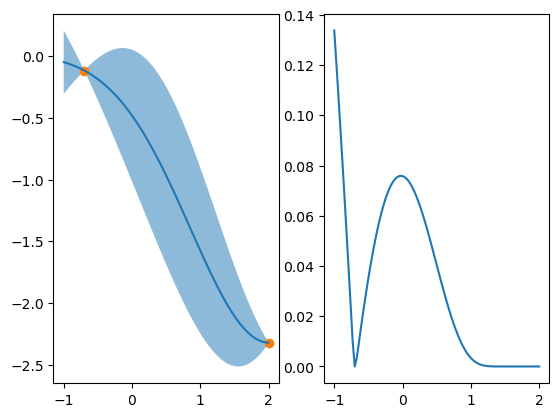

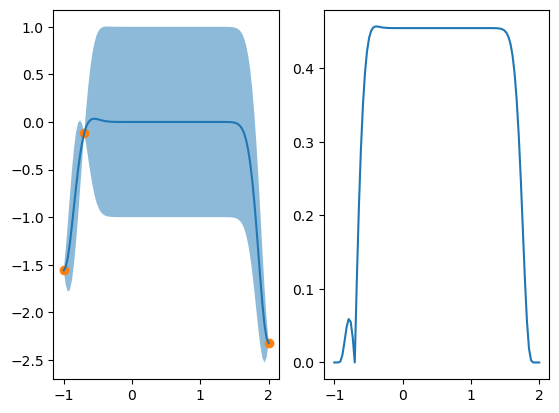

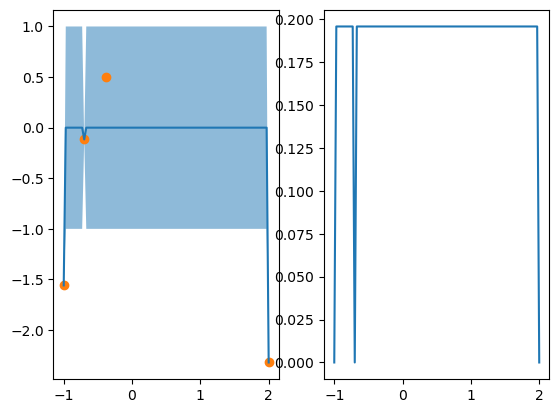

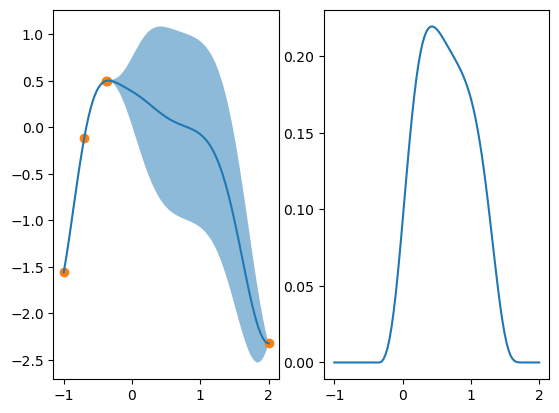

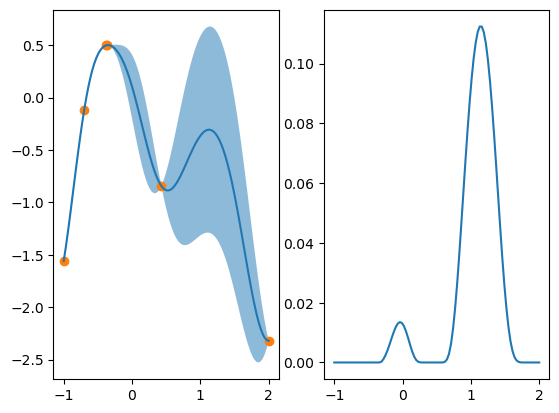

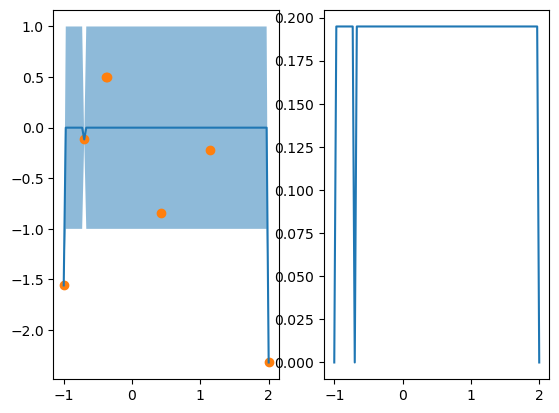

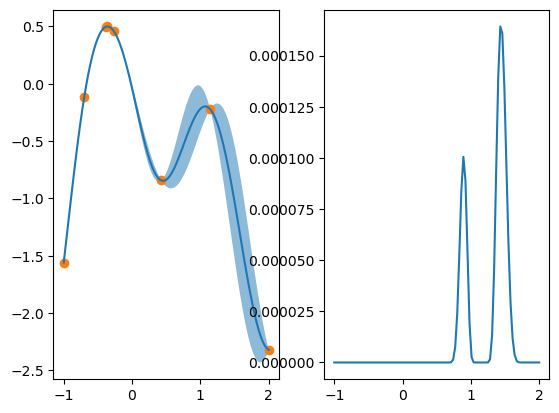

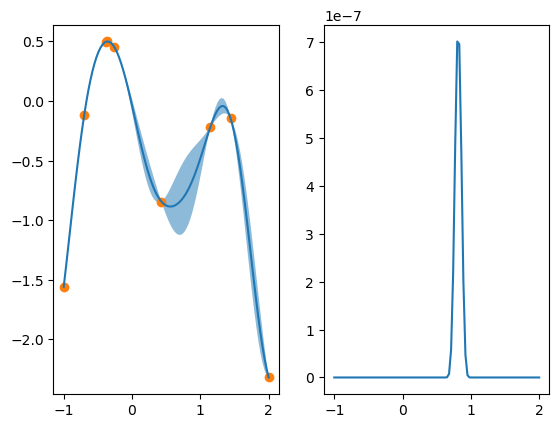

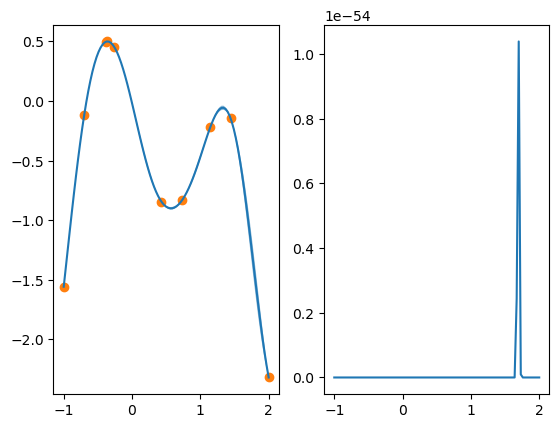

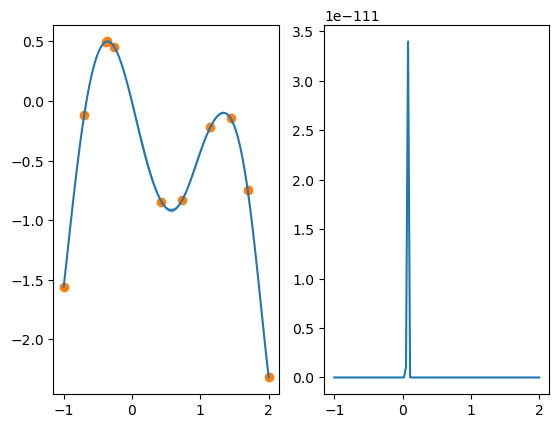

In [245]:
points_vector = points_vector_init
func_vector = func_vector_init

for _ in range(10):
    gpr.fit(points_vector,func_vector)

    acquisition_func = expected_improvement(grid.reshape(-1,1), func_vector, gpr)

    post_means,post_stds = gpr.predict(grid.reshape(-1,1),return_std=True)

    f, ax = plt.subplots(1,2)

    ax[0].fill_between(grid[0], post_means-post_stds, post_means+post_stds,alpha=0.5)
    ax[0].plot(grid[0],post_means)
    ax[0].scatter(points_vector,func_vector)

    ax[1].plot(grid[0],acquisition_func)

    next_point = get_next_location(expected_improvement,func_vector,gpr,interval)
    next_value = func(next_point)

    points_vector = np.vstack((points_vector,next_point))
    func_vector = np.vstack((func_vector,next_value))


In [246]:
def func(x):
    return -np.sin(3*x) - x**2 + 0.7*x

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.500359627666571
        x: [-3.594e-01]
      nit: 5
      jac: [ 5.551e-08]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


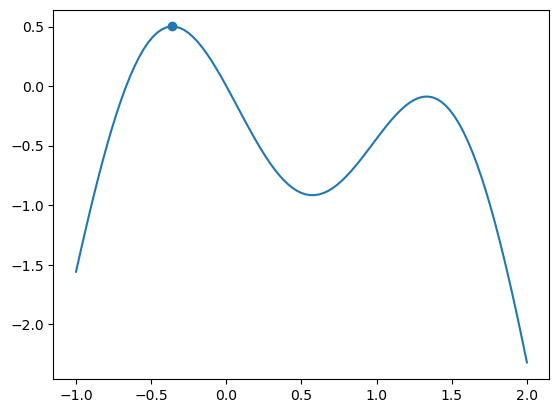

In [247]:
interval = (-1.0,2.0)
bounds = np.array([interval])
x = np.random.uniform(*interval)
def minobj(x):
    return -func(x)
res = minimize(minobj,x,bounds=bounds, method='L-BFGS-B')

print(res)

grid = np.linspace(*interval,num=101)
plt.plot(grid,func(grid))
plt.scatter(res.x,func(res.x))